# Where is Waldo?

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.ticker import MaxNLocator
import numpy as np
from PIL import Image
import os
import random
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from tqdm import tqdm

/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available
print(f"Using {device}")

Using cuda


## Data Loading

In [4]:
# Custom Dataset "WaldoDataset"
class WaldoPatchDataset(Dataset):
    def __init__(self, directories, reshape_size):
        self.filenames = []
        self.labels = []
        self.reshape_size = reshape_size
        self.to_tensor = transforms.ToTensor()

        # Loop through the directories
        for directory, label in directories:
            for fname in os.listdir(directory):
                if fname.lower().endswith('.jpg'):
                    full_path = os.path.join(directory, fname)
                    self.filenames.append(full_path)
                    self.labels.append(label)

        self.pos_labels = np.nonzero(self.labels)[0]

    # Get length
    def __len__(self):
        return len(self.filenames)
        

    def __getitem__(self, idx):
        # Load an image
        img = Image.open(self.filenames[idx])

        # Resize image
        img = img.resize(self.reshape_size)
        img = self.to_tensor(img)

        # Get the label
        label = self.labels[idx]

        return img, label

In [5]:
# Directories which contain
waldo_directories = [
    # Reshape all images to 128x128
    ("./data/64/waldo", 1),
    ("./data/64/notwaldo", 0),
    ("./data/128/waldo", 1),
    ("./data/128/notwaldo", 0)
]

# Create the dataset
waldo_dataset = WaldoPatchDataset(waldo_directories, (128, 128))

# Calculate split sizes
total_size = len(waldo_dataset)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(waldo_dataset, [train_size, val_size, test_size])

# Count labels in each subset
def count_labels_in_subset(dataset, subset):
    label_0_count = 0
    label_1_count = 0

    for idx in subset.indices:
        label = dataset.labels[idx]
        if label == 0:
            label_0_count += 1
        elif label == 1:
            label_1_count += 1

    return label_0_count, label_1_count

label_0_train_size, label_1_train_size = count_labels_in_subset(waldo_dataset, train_dataset)
label_0_val_size, label_1_val_size = count_labels_in_subset(waldo_dataset, val_dataset)
label_0_test_size, label_1_test_size = count_labels_in_subset(waldo_dataset, test_dataset)

# Print dataset statistics
print(f"Length of whole dataset: {len(waldo_dataset)}")
print("----------------------------------------------------------")
print(f"Length of the training set: {len(train_dataset)}")
print(f"Number of label 0 in the training set: {label_0_train_size}")
print(f"Number of label 1 in the training set: {label_1_train_size}")
print("----------------------------------------------------------")
print(f"Length of the validation set: {len(val_dataset)}")
print(f"Number of label 0 in the validation set: {label_0_val_size}")
print(f"Number of label 1 in the validation set: {label_1_val_size}")
print("----------------------------------------------------------")
print(f"Length of the test set: {len(test_dataset)}")
print(f"Number of label 0 in the test set: {label_0_test_size}")
print(f"Number of label 1 in the test set: {label_1_test_size}")

Length of whole dataset: 6720
----------------------------------------------------------
Length of the training set: 5443
Number of label 0 in the training set: 5390
Number of label 1 in the training set: 53
----------------------------------------------------------
Length of the validation set: 605
Number of label 0 in the validation set: 599
Number of label 1 in the validation set: 6
----------------------------------------------------------
Length of the test set: 672
Number of label 0 in the test set: 665
Number of label 1 in the test set: 7


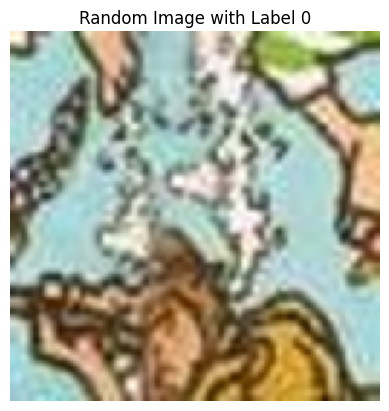

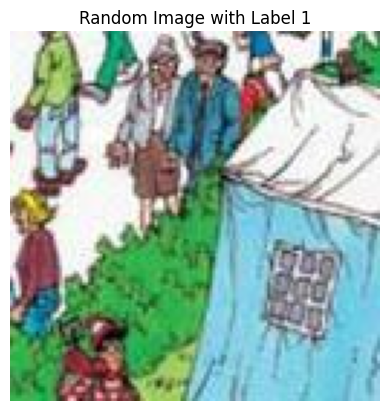

In [6]:
def show_random_image_from_each_label(dataset):
    # Get unique labels in the dataset (0 & 1)
    unique_labels = set(dataset.labels)
    # Iterate for each unique label
    for label in unique_labels:
        # Find indices for current label
        indices_for_label = [i for i, l in enumerate(dataset.labels) if l == label]

        # Choose a random index for the current label
        random_index = random.choice(indices_for_label)
        # Get the image and label
        image, _ = dataset[random_index]

        # Display the random chosen image with the label
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Random Image with Label {label}")
        plt.axis('off')
        plt.show()

show_random_image_from_each_label(waldo_dataset)

## Data Processing

In [32]:
def compute_mean_std(dataset):
    sum_rgb = torch.zeros(3)
    sum_rgb_squared = torch.zeros(3)
    num_pixels = 0
    to_tensor = transforms.ToTensor()

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten the image to get the pixel values for each channel
        sum_rgb += img.sum(dim=1)  # Sum up all the pixel values for each RGB channel
        sum_rgb_squared += (img ** 2).sum(dim=1)  # Sum up the squares of all pixel values for each RGB channel
        num_pixels += img.shape[1]  # Count the total number of pixels processed

    mean = sum_rgb / num_pixels  # Compute the mean for each RGB channel
    std = (sum_rgb_squared / num_pixels - mean ** 2).sqrt()  # Compute the standard deviation for each RGB channel

    return mean, std

mean_train, std_train = compute_mean_std(train_dataset)
print("Mean of RGB channels:", mean_train)
print("Standard Deviation of RGB channels:", *std_train)

Mean of RGB channels: tensor([0.6360, 0.5852, 0.4928])
Standard Deviation of RGB channels: tensor(0.2760) tensor(0.2842) tensor(0.2846)


## Step 1: Triplet Loss

In [72]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, aug_indices=[], aug_transforms=[]):
        self.dataset = dataset
        self.transform = transform
        self.aug_indices = aug_indices
        self.aug_transforms = aug_transforms


    def __len__(self):
        return len(self.dataset) + (len(self.aug_transforms) * len(self.aug_indices))


    def __getitem__(self, idx):
        if self.aug_indices and idx >= len(self.dataset):
            idx -= len(self.dataset)
            img_idx = self.aug_indices[idx % len(self.aug_indices)]
            transform_idx = idx // len(self.aug_indices)
            augment = True
        else:
            img_idx = idx
            augment = False
            
        img, label = self.dataset[img_idx]

        if self.transform:
            img = self.transform(img)

        if augment:
            img = self.aug_transforms[transform_idx](img)

        return img, label

In [73]:
class TripletWaldoDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = [label for _, label in subset]
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in np.unique(self.labels)}

        # Precompute negative indices for efficiency
        self.label_to_negative_indices = {label: np.where(np.array(self.labels) != label)[0]
                                          for label in np.unique(self.labels)}


    def __len__(self):
        return len(self.subset)


    def __getitem__(self, idx):
        anchor_img, anchor_label = self.subset[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])

        negative_label = np.random.choice(list(self.label_to_negative_indices.keys()))
        negative_idx = np.random.choice(self.label_to_negative_indices[negative_label])

        positive_img, _ = self.subset[positive_idx]
        negative_img, _ = self.subset[negative_idx]

        if self.transform:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [75]:
transform_normalizer = transforms.Normalize(mean_train, std_train) # Apply normalization using the computed mean and std

triplet_train_transform = transforms.Compose([
    transform_normalizer,
    transforms.RandomHorizontalFlip(p=0.2)
])

augment_transforms = [
    transforms.GaussianBlur(3),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2)
]

train_pos_labels = [
    idx
    for idx, (_, label) in enumerate(train_dataset)
    if label == 1
]

aug_train_dataset = AugmentedDataset(train_dataset, transform=transform_normalizer, aug_indices=train_pos_labels, aug_transforms=augment_transforms)
aug_val_dataset = AugmentedDataset(val_dataset, transform=transform_normalizer)
aug_test_dataset = AugmentedDataset(test_dataset, transform=transform_normalizer)

triplet_train_dataset = TripletWaldoDataset(aug_train_dataset)
triplet_val_dataset = TripletWaldoDataset(aug_val_dataset)
triplet_test_dataset = TripletWaldoDataset(aug_test_dataset)

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=16,   shuffle=True)
triplet_val_loader = DataLoader(triplet_val_dataset, batch_size=16,  shuffle=False)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=16,  shuffle=False)

In [76]:
class Patchify(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x

# Other classes (FeedForward, MultiHeadAttention, Transformer) remain unchanged
class FeedForward(nn.Module):
    def __init__(self, dim, dropout=0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout=0.):
        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    # def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=768, num_layers=6, heads=12, dropout=0.1):
    def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=256, num_layers=3, heads=8, dropout=0.1):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.patchify(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x[:, 0]  # Take the CLS token
        x = self.classifier(x)
        return x

In [77]:
# Define the triplet loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1).sqrt()  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1).sqrt()
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [78]:
def train_triplet_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    for anchor, positive, negative, _ in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate and store distances
        distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
        distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
        positive_distances.append(distance_positive)
        negative_distances.append(distance_negative)

    avg_loss = total_loss / len(train_loader)
    return avg_loss, np.mean(positive_distances), np.mean(negative_distances)


def evaluate_triplet(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    with torch.no_grad():
        for anchor, positive, negative, _ in val_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            total_loss += loss.item()

            distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
            distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
            positive_distances.append(distance_positive)
            negative_distances.append(distance_negative)

    avg_loss = total_loss / len(val_loader)
    return avg_loss, np.mean(positive_distances), np.mean(negative_distances)

In [81]:
num_epochs = 50
learning_rate = 1e-3

train_losses = []
train_positive_distances = []
train_negative_distances = []
val_losses = []
test_losses = []
test_positive_distances = []
test_negative_distances = []

best_val_loss = np.inf
best_state_dict = None

# Prepare for training and evaluation
triplet_model = ViT().to(device)
triplet_optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)
triplet_loss = TripletLoss(margin=1)
tripet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(triplet_optimizer, factor=0.5, patience=3)


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    t_loss, t_pos_dist, t_neg_dist = train_triplet_epoch(triplet_model, triplet_train_loader, triplet_optimizer, triplet_loss, device)
    train_losses.append(t_loss)
    train_positive_distances.append(t_pos_dist)
    train_negative_distances.append(t_neg_dist)

    v_loss, *_ = evaluate_triplet(triplet_model, triplet_val_loader, triplet_loss, device)
    val_losses.append(v_loss)

    te_loss, te_pos_dist, te_neg_dist = evaluate_triplet(triplet_model, triplet_test_loader, triplet_loss, device)
    test_losses.append(te_loss)
    test_positive_distances.append(te_pos_dist)
    test_negative_distances.append(te_neg_dist)

    tripet_scheduler.step(v_loss)
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_state_dict = triplet_model.state_dict()


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}')


triplet_model.load_state_dict(best_state_dict)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training Progress:   2%|▏         | 1/50 [00:28<22:59, 28.16s/it]

Epoch 1/50, Train Loss: 0.9422, Validation Loss: 1.1162


Training Progress:   4%|▍         | 2/50 [00:53<21:18, 26.64s/it]

Epoch 2/50, Train Loss: 0.9337, Validation Loss: 1.0090


Training Progress:   6%|▌         | 3/50 [01:18<20:17, 25.90s/it]

Epoch 3/50, Train Loss: 0.9087, Validation Loss: 1.0405


Training Progress:   8%|▊         | 4/50 [01:44<19:55, 25.99s/it]

Epoch 4/50, Train Loss: 0.9156, Validation Loss: 1.0395


Training Progress:  10%|█         | 5/50 [02:09<19:09, 25.55s/it]

Epoch 5/50, Train Loss: 0.9356, Validation Loss: 1.0699


Training Progress:  12%|█▏        | 6/50 [02:34<18:38, 25.43s/it]

Epoch 6/50, Train Loss: 0.9118, Validation Loss: 1.1086


Training Progress:  14%|█▍        | 7/50 [03:01<18:26, 25.74s/it]

Epoch 7/50, Train Loss: 0.8905, Validation Loss: 1.0935


Training Progress:  16%|█▌        | 8/50 [03:26<17:54, 25.58s/it]

Epoch 8/50, Train Loss: 0.8595, Validation Loss: 1.0688


Training Progress:  18%|█▊        | 9/50 [03:51<17:21, 25.39s/it]

Epoch 9/50, Train Loss: 0.8472, Validation Loss: 1.0871


Training Progress:  20%|██        | 10/50 [04:17<17:02, 25.56s/it]

Epoch 10/50, Train Loss: 0.8548, Validation Loss: 1.0519


Training Progress:  22%|██▏       | 11/50 [04:42<16:37, 25.57s/it]

Epoch 11/50, Train Loss: 0.8586, Validation Loss: 1.0660


Training Progress:  24%|██▍       | 12/50 [05:09<16:20, 25.79s/it]

Epoch 12/50, Train Loss: 0.8516, Validation Loss: 1.0738


Training Progress:  26%|██▌       | 13/50 [05:33<15:37, 25.35s/it]

Epoch 13/50, Train Loss: 0.8563, Validation Loss: 1.0611


Training Progress:  28%|██▊       | 14/50 [05:59<15:15, 25.43s/it]

Epoch 14/50, Train Loss: 0.8265, Validation Loss: 1.0743


Training Progress:  30%|███       | 15/50 [06:24<14:46, 25.32s/it]

Epoch 15/50, Train Loss: 0.8361, Validation Loss: 1.0554


Training Progress:  32%|███▏      | 16/50 [06:49<14:23, 25.41s/it]

Epoch 16/50, Train Loss: 0.8251, Validation Loss: 1.0757


Training Progress:  34%|███▍      | 17/50 [07:15<13:56, 25.35s/it]

Epoch 17/50, Train Loss: 0.8142, Validation Loss: 1.1007


Training Progress:  36%|███▌      | 18/50 [07:40<13:32, 25.38s/it]

Epoch 18/50, Train Loss: 0.7993, Validation Loss: 0.9741


Training Progress:  38%|███▊      | 19/50 [08:06<13:13, 25.59s/it]

Epoch 19/50, Train Loss: 0.7844, Validation Loss: 0.9969


Training Progress:  40%|████      | 20/50 [08:32<12:51, 25.70s/it]

Epoch 20/50, Train Loss: 0.7556, Validation Loss: 1.0789


Training Progress:  42%|████▏     | 21/50 [08:59<12:39, 26.19s/it]

Epoch 21/50, Train Loss: 0.7563, Validation Loss: 0.9682


Training Progress:  44%|████▍     | 22/50 [09:26<12:14, 26.23s/it]

Epoch 22/50, Train Loss: 0.7706, Validation Loss: 1.0111


Training Progress:  46%|████▌     | 23/50 [09:52<11:46, 26.16s/it]

Epoch 23/50, Train Loss: 0.7469, Validation Loss: 0.9497


Training Progress:  48%|████▊     | 24/50 [10:19<11:31, 26.61s/it]

Epoch 24/50, Train Loss: 0.7364, Validation Loss: 0.9980


Training Progress:  50%|█████     | 25/50 [10:47<11:09, 26.80s/it]

Epoch 25/50, Train Loss: 0.7513, Validation Loss: 0.9568


Training Progress:  52%|█████▏    | 26/50 [11:14<10:47, 26.99s/it]

Epoch 26/50, Train Loss: 0.7392, Validation Loss: 0.9863


Training Progress:  54%|█████▍    | 27/50 [11:42<10:27, 27.28s/it]

Epoch 27/50, Train Loss: 0.7248, Validation Loss: 0.9740


Training Progress:  56%|█████▌    | 28/50 [12:09<09:56, 27.13s/it]

Epoch 28/50, Train Loss: 0.7243, Validation Loss: 0.9565


Training Progress:  58%|█████▊    | 29/50 [12:37<09:34, 27.33s/it]

Epoch 29/50, Train Loss: 0.7236, Validation Loss: 0.9769


Training Progress:  60%|██████    | 30/50 [13:03<09:02, 27.13s/it]

Epoch 30/50, Train Loss: 0.7139, Validation Loss: 0.9978


Training Progress:  62%|██████▏   | 31/50 [13:29<08:24, 26.56s/it]

Epoch 31/50, Train Loss: 0.7076, Validation Loss: 0.9690


Training Progress:  64%|██████▍   | 32/50 [13:55<07:58, 26.61s/it]

Epoch 32/50, Train Loss: 0.6994, Validation Loss: 0.9730


Training Progress:  66%|██████▌   | 33/50 [14:22<07:31, 26.57s/it]

Epoch 33/50, Train Loss: 0.7047, Validation Loss: 0.9285


Training Progress:  68%|██████▊   | 34/50 [14:47<06:58, 26.18s/it]

Epoch 34/50, Train Loss: 0.7018, Validation Loss: 0.9227


Training Progress:  70%|███████   | 35/50 [15:13<06:33, 26.22s/it]

Epoch 35/50, Train Loss: 0.6985, Validation Loss: 0.9698


Training Progress:  72%|███████▏  | 36/50 [15:38<06:02, 25.86s/it]

Epoch 36/50, Train Loss: 0.6985, Validation Loss: 0.9343


Training Progress:  74%|███████▍  | 37/50 [16:03<05:32, 25.56s/it]

Epoch 37/50, Train Loss: 0.6929, Validation Loss: 0.9718


Training Progress:  76%|███████▌  | 38/50 [16:30<05:09, 25.81s/it]

Epoch 38/50, Train Loss: 0.6946, Validation Loss: 0.9207


Training Progress:  78%|███████▊  | 39/50 [16:56<04:44, 25.88s/it]

Epoch 39/50, Train Loss: 0.6895, Validation Loss: 1.0039


Training Progress:  80%|████████  | 40/50 [17:22<04:21, 26.14s/it]

Epoch 40/50, Train Loss: 0.6815, Validation Loss: 1.0077


Training Progress:  82%|████████▏ | 41/50 [17:50<03:58, 26.50s/it]

Epoch 41/50, Train Loss: 0.6872, Validation Loss: 1.0011


Training Progress:  84%|████████▍ | 42/50 [18:17<03:34, 26.87s/it]

Epoch 42/50, Train Loss: 0.6904, Validation Loss: 0.9799


Training Progress:  86%|████████▌ | 43/50 [18:43<03:06, 26.57s/it]

Epoch 43/50, Train Loss: 0.6759, Validation Loss: 0.9428


Training Progress:  88%|████████▊ | 44/50 [19:10<02:40, 26.71s/it]

Epoch 44/50, Train Loss: 0.6682, Validation Loss: 0.9674


Training Progress:  90%|█████████ | 45/50 [19:36<02:12, 26.47s/it]

Epoch 45/50, Train Loss: 0.6688, Validation Loss: 0.9709


Training Progress:  92%|█████████▏| 46/50 [20:04<01:47, 26.97s/it]

Epoch 46/50, Train Loss: 0.6725, Validation Loss: 0.9798


Training Progress:  94%|█████████▍| 47/50 [23:01<03:35, 71.90s/it]

Epoch 47/50, Train Loss: 0.6770, Validation Loss: 0.9761


Training Progress:  96%|█████████▌| 48/50 [23:22<01:53, 56.58s/it]

Epoch 48/50, Train Loss: 0.6656, Validation Loss: 0.9478


Training Progress:  98%|█████████▊| 49/50 [23:43<00:45, 45.95s/it]

Epoch 49/50, Train Loss: 0.6680, Validation Loss: 0.9564


Training Progress: 100%|██████████| 50/50 [24:04<00:00, 28.89s/it]

Epoch 50/50, Train Loss: 0.6720, Validation Loss: 0.9868


<All keys matched successfully>

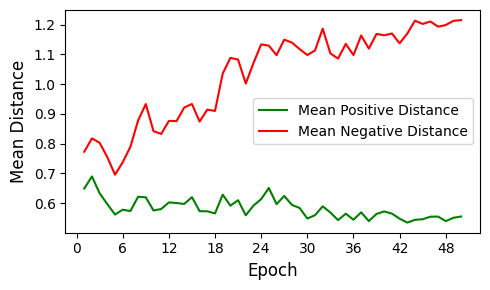

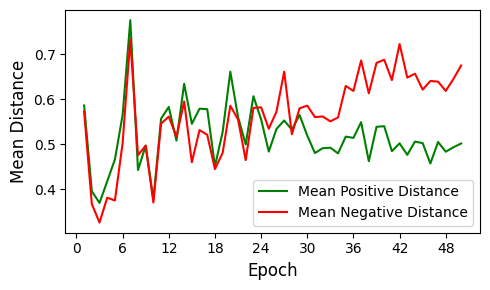

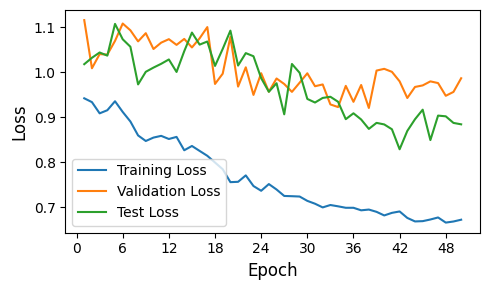

In [82]:
epochs = list(range(1, num_epochs + 1))

# Plot training distances
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_positive_distances, label='Mean Positive Distance', color='g')
ax.plot(epochs, train_negative_distances, label='Mean Negative Distance', color='r')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Mean Distance', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/train_distance.svg')
plt.show()

# Plot test distances
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, test_positive_distances, label='Mean Positive Distance', color='g')
ax.plot(epochs, test_negative_distances, label='Mean Negative Distance', color='r')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Mean Distance', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/test_distance.svg')
plt.show()

# Plot losses
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, val_losses, label='Validation Loss')
ax.plot(epochs, test_losses, label='Test Loss')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/loss.svg')
plt.show()


In [83]:
# Save the model state
torch.save(triplet_model.state_dict(), './checkpoints/triplet_model_state_dict.pth')

In [106]:
triplet_model = ViT().to(device)
triplet_model.load_state_dict(torch.load('./checkpoints/triplet_model_state_dict.pth'))

<All keys matched successfully>

## Part 2: Binary classification

In [105]:
augment_transforms = [
    transforms.GaussianBlur(3),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2)
] * 20 + [lambda x: x] * 80

train_pos_labels = [
    idx
    for idx, (_, label) in enumerate(train_dataset)
    if label == 1
]

aug_train_dataset = AugmentedDataset(train_dataset, transform=transform_normalizer, aug_indices=train_pos_labels, aug_transforms=augment_transforms)
aug_val_dataset = AugmentedDataset(val_dataset, transform=transform_normalizer)
aug_test_dataset = AugmentedDataset(test_dataset, transform=transform_normalizer)

binary_train_loader = DataLoader(aug_train_dataset, batch_size=16, shuffle=True)
binary_val_loader = DataLoader(aug_val_dataset, batch_size=16, shuffle=False)
binary_test_loader = DataLoader(aug_test_dataset, batch_size=16, shuffle=False)

In [100]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, vit_model, freeze=False):
        super(BinaryClassificationModel, self).__init__()
        self.vit_model = vit_model
        if freeze:
            # Freeze pretrained layers
            for param in self.vit_model.parameters():
                param.requires_grad = False

        in_features = self.vit_model.classifier[1].in_features
        self.vit_model.classifier[1] = nn.Linear(in_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.vit_model(x)
        x = self.sigmoid(x)
        return x.squeeze(1)

In [101]:
def train_binary(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        outputs = model(data)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss
    

def evaluate_binary_metrics(model, data_loader, loss_fn, device, metrics=[]):
    model.eval()
    total_loss = 0
    all_expected_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.float()

            outputs = model(data)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            predictions = (outputs > 0.5).float()
            all_expected_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    results = [avg_loss]
    for metric in metrics:
        score = metric(all_expected_labels, all_predicted_labels)
        results.append(score)

    return results

In [107]:
num_epochs = 50
learning_rate = 1e-5

train_losses = []
val_losses = []
test_losses = []
test_f1s = []
test_precisions = []
test_recalls = []
test_metrics = [
    f1_score,
    precision_score,
    recall_score
]

best_val_loss = np.inf
best_state_dict = None

binary_model = BinaryClassificationModel(triplet_model).to(device)
binary_optimizer = torch.optim.Adam(binary_model.parameters(), lr=learning_rate)
binary_criterion = torch.nn.BCELoss()
binary_scheduler = optim.lr_scheduler.ReduceLROnPlateau(triplet_optimizer, factor=0.5, patience=2)


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    t_loss = train_binary(binary_model, binary_train_loader, binary_optimizer, binary_criterion, device)
    train_losses.append(t_loss)

    v_loss, *_ = evaluate_binary_metrics(binary_model, binary_val_loader, binary_criterion, device)
    val_losses.append(v_loss)

    te_loss, te_f1, te_prec, te_rec = evaluate_binary_metrics(binary_model, binary_val_loader, binary_criterion, device, test_metrics)
    test_losses.append(te_loss)
    test_f1s.append(te_f1)
    test_precisions.append(te_prec)
    test_recalls.append(te_rec)
    
    binary_scheduler.step(v_loss)
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_state_dict = binary_model.state_dict()


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}')


binary_model.load_state_dict(best_state_dict)

Training Progress:   2%|▏         | 1/50 [00:32<26:32, 32.50s/it]

Epoch 1/50, Train Loss: 0.3815, Validation Loss: 0.7961


Training Progress:   4%|▍         | 2/50 [01:05<26:20, 32.93s/it]

Epoch 2/50, Train Loss: 0.2809, Validation Loss: 0.7463


Training Progress:   6%|▌         | 3/50 [01:38<25:50, 33.00s/it]

Epoch 3/50, Train Loss: 0.2623, Validation Loss: 0.6610


Training Progress:   8%|▊         | 4/50 [02:10<24:56, 32.54s/it]

Epoch 4/50, Train Loss: 0.2490, Validation Loss: 0.5959


Training Progress:  10%|█         | 5/50 [02:42<24:14, 32.33s/it]

Epoch 5/50, Train Loss: 0.2417, Validation Loss: 0.5828


Training Progress:  12%|█▏        | 6/50 [03:14<23:40, 32.28s/it]

Epoch 6/50, Train Loss: 0.2332, Validation Loss: 0.5646


Training Progress:  14%|█▍        | 7/50 [03:47<23:11, 32.36s/it]

Epoch 7/50, Train Loss: 0.2256, Validation Loss: 0.5466


Training Progress:  16%|█▌        | 8/50 [04:19<22:39, 32.37s/it]

Epoch 8/50, Train Loss: 0.2217, Validation Loss: 0.5122


Training Progress:  18%|█▊        | 9/50 [04:52<22:07, 32.38s/it]

Epoch 9/50, Train Loss: 0.2135, Validation Loss: 0.5694


Training Progress:  20%|██        | 10/50 [05:24<21:40, 32.52s/it]

Epoch 10/50, Train Loss: 0.2050, Validation Loss: 0.5021


Training Progress:  22%|██▏       | 11/50 [05:57<21:09, 32.56s/it]

Epoch 11/50, Train Loss: 0.2008, Validation Loss: 0.5299


Training Progress:  24%|██▍       | 12/50 [06:30<20:37, 32.58s/it]

Epoch 12/50, Train Loss: 0.1911, Validation Loss: 0.4686


Training Progress:  26%|██▌       | 13/50 [07:03<20:09, 32.68s/it]

Epoch 13/50, Train Loss: 0.1846, Validation Loss: 0.4525


Training Progress:  28%|██▊       | 14/50 [07:36<19:43, 32.87s/it]

Epoch 14/50, Train Loss: 0.1794, Validation Loss: 0.4277


Training Progress:  30%|███       | 15/50 [08:09<19:14, 32.97s/it]

Epoch 15/50, Train Loss: 0.1714, Validation Loss: 0.3876


Training Progress:  32%|███▏      | 16/50 [08:42<18:39, 32.92s/it]

Epoch 16/50, Train Loss: 0.1683, Validation Loss: 0.4252


Training Progress:  34%|███▍      | 17/50 [09:15<18:08, 32.98s/it]

Epoch 17/50, Train Loss: 0.1613, Validation Loss: 0.3611


Training Progress:  36%|███▌      | 18/50 [09:50<17:54, 33.58s/it]

Epoch 18/50, Train Loss: 0.1495, Validation Loss: 0.3767


Training Progress:  38%|███▊      | 19/50 [10:26<17:44, 34.35s/it]

Epoch 19/50, Train Loss: 0.1412, Validation Loss: 0.3312


Training Progress:  40%|████      | 20/50 [11:01<17:18, 34.63s/it]

Epoch 20/50, Train Loss: 0.1340, Validation Loss: 0.3004


Training Progress:  42%|████▏     | 21/50 [11:35<16:32, 34.21s/it]

Epoch 21/50, Train Loss: 0.1259, Validation Loss: 0.3100


Training Progress:  44%|████▍     | 22/50 [12:07<15:45, 33.76s/it]

Epoch 22/50, Train Loss: 0.1179, Validation Loss: 0.3202


Training Progress:  46%|████▌     | 23/50 [12:40<15:01, 33.38s/it]

Epoch 23/50, Train Loss: 0.1072, Validation Loss: 0.3302


Training Progress:  48%|████▊     | 24/50 [13:13<14:22, 33.17s/it]

Epoch 24/50, Train Loss: 0.0944, Validation Loss: 0.3177


Training Progress:  50%|█████     | 25/50 [13:46<13:47, 33.10s/it]

Epoch 25/50, Train Loss: 0.0900, Validation Loss: 0.2940


Training Progress:  52%|█████▏    | 26/50 [14:20<13:24, 33.51s/it]

Epoch 26/50, Train Loss: 0.0845, Validation Loss: 0.2736


Training Progress:  54%|█████▍    | 27/50 [14:54<12:52, 33.57s/it]

Epoch 27/50, Train Loss: 0.0785, Validation Loss: 0.2614


Training Progress:  56%|█████▌    | 28/50 [15:28<12:22, 33.74s/it]

Epoch 28/50, Train Loss: 0.0712, Validation Loss: 0.2851


Training Progress:  58%|█████▊    | 29/50 [16:02<11:52, 33.91s/it]

Epoch 29/50, Train Loss: 0.0683, Validation Loss: 0.2315


Training Progress:  60%|██████    | 30/50 [16:36<11:20, 34.01s/it]

Epoch 30/50, Train Loss: 0.0651, Validation Loss: 0.2519


Training Progress:  62%|██████▏   | 31/50 [17:10<10:41, 33.75s/it]

Epoch 31/50, Train Loss: 0.0613, Validation Loss: 0.2655


Training Progress:  64%|██████▍   | 32/50 [17:43<10:04, 33.58s/it]

Epoch 32/50, Train Loss: 0.0602, Validation Loss: 0.2449


Training Progress:  66%|██████▌   | 33/50 [18:16<09:27, 33.40s/it]

Epoch 33/50, Train Loss: 0.0590, Validation Loss: 0.2360


Training Progress:  68%|██████▊   | 34/50 [18:49<08:52, 33.30s/it]

Epoch 34/50, Train Loss: 0.0517, Validation Loss: 0.2454


Training Progress:  70%|███████   | 35/50 [19:22<08:20, 33.38s/it]

Epoch 35/50, Train Loss: 0.0503, Validation Loss: 0.2119


Training Progress:  72%|███████▏  | 36/50 [19:56<07:50, 33.62s/it]

Epoch 36/50, Train Loss: 0.0493, Validation Loss: 0.2443


Training Progress:  74%|███████▍  | 37/50 [20:31<07:20, 33.92s/it]

Epoch 37/50, Train Loss: 0.0468, Validation Loss: 0.2512


Training Progress:  76%|███████▌  | 38/50 [21:06<06:50, 34.21s/it]

Epoch 38/50, Train Loss: 0.0481, Validation Loss: 0.2289


Training Progress:  78%|███████▊  | 39/50 [21:41<06:19, 34.49s/it]

Epoch 39/50, Train Loss: 0.0445, Validation Loss: 0.2506


Training Progress:  80%|████████  | 40/50 [22:16<05:44, 34.49s/it]

Epoch 40/50, Train Loss: 0.0407, Validation Loss: 0.2132


Training Progress:  82%|████████▏ | 41/50 [22:51<05:12, 34.69s/it]

Epoch 41/50, Train Loss: 0.0425, Validation Loss: 0.2206


Training Progress:  84%|████████▍ | 42/50 [23:26<04:38, 34.76s/it]

Epoch 42/50, Train Loss: 0.0400, Validation Loss: 0.2285


Training Progress:  86%|████████▌ | 43/50 [24:01<04:03, 34.80s/it]

Epoch 43/50, Train Loss: 0.0382, Validation Loss: 0.2115


Training Progress:  88%|████████▊ | 44/50 [24:36<03:29, 34.87s/it]

Epoch 44/50, Train Loss: 0.0355, Validation Loss: 0.2297


Training Progress:  90%|█████████ | 45/50 [25:10<02:53, 34.64s/it]

Epoch 45/50, Train Loss: 0.0320, Validation Loss: 0.2231


Training Progress:  92%|█████████▏| 46/50 [25:44<02:18, 34.55s/it]

Epoch 46/50, Train Loss: 0.0305, Validation Loss: 0.2282


Training Progress:  94%|█████████▍| 47/50 [26:19<01:44, 34.75s/it]

Epoch 47/50, Train Loss: 0.0339, Validation Loss: 0.2257


Training Progress:  96%|█████████▌| 48/50 [26:54<01:09, 34.76s/it]

Epoch 48/50, Train Loss: 0.0304, Validation Loss: 0.2342


Training Progress:  98%|█████████▊| 49/50 [27:28<00:34, 34.61s/it]

Epoch 49/50, Train Loss: 0.0285, Validation Loss: 0.2301


Training Progress: 100%|██████████| 50/50 [28:03<00:00, 33.66s/it]

Epoch 50/50, Train Loss: 0.0280, Validation Loss: 0.2426


<All keys matched successfully>

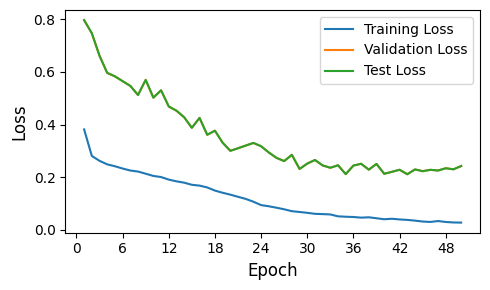

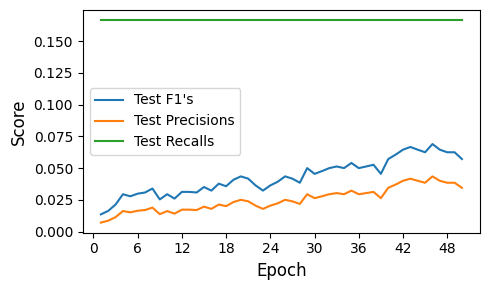

In [108]:
epochs = list(range(1, num_epochs + 1))

# Plot losses
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, val_losses, label='Validation Loss')
ax.plot(epochs, test_losses, label='Test Loss')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_2/loss.svg')
plt.show()

# Plot test metrics
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, test_f1s, label='Test F1\'s')
ax.plot(epochs, test_precisions, label='Test Precisions')
ax.plot(epochs, test_recalls, label='Test Recalls')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Score', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_2/test_metrics.svg')
plt.show()

In [109]:
test_metrics = [
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
]

(
    test_loss,
    test_accuracy,
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_conf_matrix
) = evaluate_binary_metrics(binary_model, binary_test_loader, binary_criterion, device, test_metrics)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')
print(f'Test Confusion Matrix:\n{test_conf_matrix}')

Test Loss: 0.2524
Test Accuracy: 0.9494
Test Precision: 0.0909
Test Recall: 0.4286
Test F1-Score: 0.1500
Test ROC AUC: 0.6917
Test Confusion Matrix:
[[635  30]
 [  4   3]]


In [110]:
# Save the model state
torch.save(binary_model.state_dict(), './checkpoints/binary_model_state_dict.pth')

In [141]:
binary_model = BinaryClassificationModel(triplet_model).to(device)
binary_model.load_state_dict(torch.load('./checkpoints/binary_model_state_dict.pth'))

<All keys matched successfully>

## Part 3: Object detection

In [126]:
class WaldoFullImagesDataset(Dataset):
    def __init__(self, labelled_files, reshape_size, transform=None):
        self.filenames = []
        self.waldo_boxes = []
        self.reshape_size = reshape_size
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        for filename, (x1, y1, x2, y2) in labelled_files:
            self.filenames.append(filename)
            self.waldo_boxes.append(np.array([x1, y1, x2, y2]))


    # Get length
    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, idx):
        # Load the image in memory
        img = Image.open(self.filenames[idx])
        img_width, img_height = img.size

        # Resize and transform the image
        img = img.resize(self.reshape_size)
        img = self.to_tensor(img)
        if self.transform:
            img = self.transform(img)

        # Get image label
        _, height, width = img.shape
        waldo_box = self.waldo_boxes[idx]
        waldo_box = waldo_box.astype(float)
        waldo_box[::2] *= width / img_width
        waldo_box[1::2] *= height / img_height

        return img, waldo_box

In [130]:
metadata_filepath = './waldo_metadata.csv'
labelled_files = []

with open(metadata_filepath) as meta_file:
    waldo_csv = csv.reader(meta_file, delimiter=',')
    for img_row in waldo_csv:
        img_path, x1, y1, x2, y2 = img_row
        waldo_box = int(x1), int(y1), int(x2), int(y2)
        labelled_files.append((img_path, waldo_box))

# Calculate split sizes
total_size = len(labelled_files)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

patch_dataset = WaldoFullImagesDataset(labelled_files, (640, 640))

# Split the dataset
patch_train_split, patch_val_split, patch_test_split = random_split(patch_dataset, [train_size, val_size, test_size])

patch_trans_train_dataset = AugmentedDataset(patch_train_split, transform=transform_normalizer)
patch_trans_val_dataset = AugmentedDataset(patch_val_split, transform=transform_normalizer)
patch_trans_test_dataset = AugmentedDataset(patch_test_split, transform=transform_normalizer)

patch_train_loader = DataLoader(patch_trans_train_dataset, batch_size=1, shuffle=True)
patch_val_loader = DataLoader(patch_trans_val_dataset, batch_size=1, shuffle=True)
patch_test_loader = DataLoader(patch_trans_test_dataset, batch_size=1, shuffle=False)

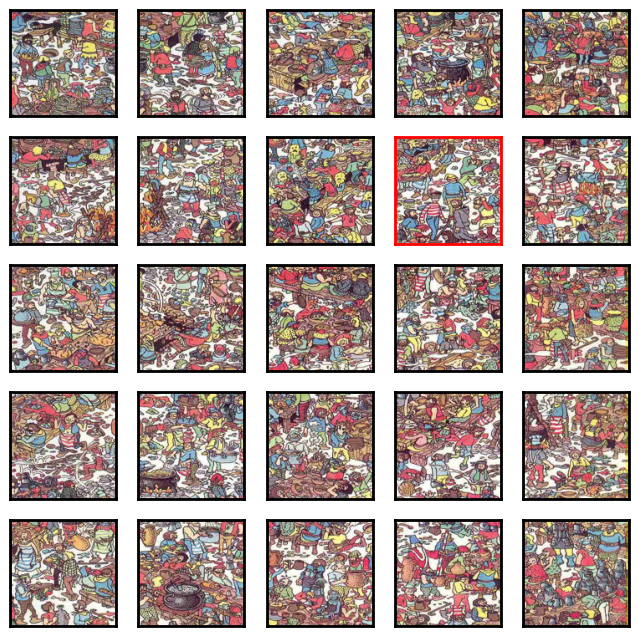

In [134]:
def show_image_patches(img, patch, patches_div):
    # Patchify image
    depth, height, width = img.shape
    patches_h = height // patches_div
    patches_w = width // patches_div
    patchified_img = img.unfold(1, patches_h, patches_h).unfold(2, patches_w, patches_w)

    patch_h, patch_w = patch

    # Display the random chosen image with the label
    fig, axs = plt.subplots(patches_div, patches_div, figsize=(8, 8))
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            patch = patchified_img[:, i, j, :, :].permute(1, 2, 0)
            ax.imshow(patch)
            ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                if i == patch_h and j == patch_w:
                    spine.set_edgecolor('red')
    plt.show()


def show_random_image_patches(dataset, paches_div):
    # Choose a random index for image
    random_idx = random.randint(0, len(dataset) - 1)
    # Get the image and label
    img, waldo_lbl = dataset[random_idx]

    # Get Waldo patch idx
    depth, height, width = img.shape
    waldo_mid = (waldo_lbl[:2] + waldo_lbl[2:]) / 2
    waldo_patch_h = int(waldo_mid[1] / (height / patches_div))
    waldo_patch_w = int(waldo_mid[0] / (width / patches_div))
    patch = (waldo_patch_h, waldo_patch_w)

    show_image_patches(img, patch, paches_div)


show_random_image_patches(patch_dataset, 5)

In [135]:
class PatchBasedClassification(nn.Module):
    def __init__(self, classifier, patches_div, freeze=False):
        super().__init__()
        self.classifier = classifier
        if freeze:
            # Freeze pretrained layers
            for param in self.vit_model.parameters():
                param.requires_grad = False
        self.patches_div = patches_div
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        # Patchify image
        *_, depth, height, width = x.shape
        patches_h = height // self.patches_div
        patches_w = width // self.patches_div
        x = x.unfold(2, patches_h, patches_h).unfold(3, patches_w, patches_w)
        x = x.reshape(-1, 3, patches_h, patches_w)

        # Run through classifier
        x = self.classifier(x)
        x = x.reshape(-1, self.patches_div * self.patches_div)

        # Calculate probabilities per patch
        # x = self.sigmoid(x)
        x = self.softmax(x)
        x = x.reshape(-1, self.patches_div, self.patches_div)
        
        return x       

In [136]:
def calculate_iou(boxes_prd, boxes_lbl):
    # box = (x1, x2, y1, y2) = (left x, top y, right x, bottom y)

    # Calculate intersection...
    #  Calculate inner box (x, y): max from left and top, min from right and bottom
    lt_inner = np.maximum(boxes_prd[..., :2], boxes_lbl[..., :2])
    rb_inner = np.minimum(boxes_prd[..., 2:], boxes_lbl[..., 2:])
    #  Calculate base = r - l, height = b - t and area = base * height
    bh_inner = np.maximum(rb_inner - lt_inner, 0)
    area_inner = bh_inner[..., 0] * bh_inner[..., 1]
    
    # Calculate union...
    #  Calculate base, height
    bh_prd = boxes_prd[..., 2:] - boxes_prd[..., :2]
    bh_lbl = boxes_lbl[..., 2:] - boxes_lbl[..., :2]
    #  Calculate both areas
    area_prd = bh_prd[..., 0] * bh_prd[..., 1]
    area_lbl = bh_lbl[..., 0] * bh_lbl[..., 1]
    #  Inner area counted twice
    area_outer = area_prd + area_lbl - area_inner

    # Intersection over union
    return area_inner / area_outer

In [137]:
# As defined in https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html
def calculate_ap(precisions, recalls):
    recalls_pad = np.concatenate([[0.], recalls, [1.]])
    recall_lvls = np.linspace(0, 1, 11)

    # Calculate the 11-point interpolated average precision
    eleven_point_ap = np.mean([
        np.max(np.concatenate([
            precisions[recalls >= recall_lvl],
            [0.0] # fallback
        ]))
        for recall_lvl in recall_lvls
    ])
    
    return eleven_point_ap


# Simplified algorithm from https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/
def calculate_map(boxes_prd, boxes_lbl, iou_threshold=0.5, eps=np.finfo(float).eps):
    # True positive and false positive flag vector
    tp_flg = np.zeros(len(boxes_prd))
    fp_flg = np.zeros(len(boxes_prd))

    # Calculate true and false positives using IOUs
    ious = calculate_iou(boxes_prd, boxes_lbl)
    tp_flg = (ious >= iou_threshold).astype(int)
    fp_flg = ~tp_flg

    # Generate vectors of precisions and recalls
    tp_cs = np.cumsum(tp_flg)
    fp_cs = np.cumsum(fp_flg)
    precisions = tp_cs / np.minimum(tp_cs + fp_cs, eps)
    recalls = tp_cs / len(boxes_lbl)

    # Calculate average precision for class
    #  Only Waldo objects are being detected so mAP = AP
    return calculate_ap(precisions, recalls)

In [138]:
def patches_lbl_from_boxes(boxes_lbl, img_shape, patches_div):
    *_, height, width = img_shape
    prd_mid = (boxes_lbl[..., :2] + boxes_lbl[..., 2:]) / 2
    prd_patch_h = torch.floor(prd_mid[..., 1] / (height / patches_div)).int()
    prd_patch_w = torch.floor(prd_mid[..., 0] / (width / patches_div)).int()
    
    patches_prd = torch.zeros(len(boxes_lbl), patches_div, patches_div)
    patches_prd[..., prd_patch_h, prd_patch_w] = 1

    return patches_prd

def boxes_from_patches_prd(patches_prd_flat, img_shape, patches_div):
    patches_max = patches_prd_flat.argmax(-1)
    patches_max_idx = np.concatenate([
        np.array([divmod(idx.item(), patches_div)])
        for idx in patches_max
    ])

    *_, height, width = img_shape
    boxes_prd = np.zeros((len(patches_prd_flat), 4))
    boxes_prd[..., 0] = np.floor(patches_max_idx[..., 1] * (width / patches_div))
    boxes_prd[..., 1] = np.floor(patches_max_idx[..., 0] * (height / patches_div))
    boxes_prd[..., 2] = np.floor((patches_max_idx[..., 1] + 1) * (width / patches_div))
    boxes_prd[..., 3] = np.floor((patches_max_idx[..., 0] + 1) * (height / patches_div))

    return boxes_prd 

In [139]:
def train_patch_epoch(model, train_loader, optimizer, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.train()
    total_loss = 0
    train_boxes_prd = []
    train_boxes_lbl = []
    correct_prd = []

    for img_batch, boxes_lbl in train_loader:
        img_batch = img_batch.to(device)

        optimizer.zero_grad()

        patches_prd = model(img_batch)
        patches_lbl = patches_lbl_from_boxes(boxes_lbl, img_batch.shape, patches_div).to(device)

        patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
        patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

        loss = loss_fn(patches_prd_flat, patches_lbl_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        correct = (patches_prd_flat.argmax(-1) == patches_lbl_flat.argmax(-1)).float()
        correct_prd.append(correct.detach().cpu().numpy())

        # Store predicted boxes and label boxes
        boxes_prd = boxes_from_patches_prd(patches_prd_flat.detach().cpu().numpy(), img_batch.shape, patches_div)
        train_boxes_prd.append(boxes_prd)
        train_boxes_lbl.append(boxes_lbl.detach().cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    train_boxes_prd = np.concatenate(train_boxes_prd)
    train_boxes_lbl = np.concatenate(train_boxes_lbl)
    train_ious = calculate_iou(train_boxes_prd, train_boxes_lbl)
    train_map = calculate_map(train_boxes_prd, train_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(correct_prd), np.mean(train_ious), train_map


def evaluate_patch(model, test_loader, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.eval()
    total_loss = 0
    test_boxes_prd = []
    test_boxes_lbl = []
    correct_prd = []

    with torch.no_grad():
        for img_batch, boxes_lbl in test_loader:
            img_batch = img_batch.to(device)

            patches_prd = model(img_batch)
            patches_lbl = patches_lbl_from_boxes(boxes_lbl, img_batch.shape, patches_div).to(device)

            patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
            patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

            loss = loss_fn(patches_prd_flat, patches_lbl_flat)
            total_loss += loss.item()

            correct = (patches_prd_flat.argmax(-1) == patches_lbl_flat.argmax(-1)).float()
            correct_prd.append(correct.detach().cpu().numpy())

            # Store predicted boxes and label boxes
            boxes_prd = boxes_from_patches_prd(patches_prd_flat.detach().cpu().numpy(), img_batch.shape, patches_div)
            test_boxes_prd.append(boxes_prd)
            test_boxes_lbl.append(boxes_lbl.detach().cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    test_boxes_prd = np.concatenate(test_boxes_prd)
    test_boxes_lbl = np.concatenate(test_boxes_lbl)
    test_ious = calculate_iou(test_boxes_prd, test_boxes_lbl)
    test_map = calculate_map(test_boxes_prd, test_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(correct_prd), np.mean(test_ious), test_map

In [143]:
num_epochs = 50
learning_rate = 1e-5
patches_div = 5

train_losses = []
train_iou = []
train_map = []
train_acc = []
val_losses = []
test_losses = []
test_iou = []
test_map = []
test_acc = []

best_val_loss = np.inf
best_state_dict = None


# Prepare for training and evaluation
patch_model = PatchBasedClassification(binary_model, patches_div).to(device)
patch_optimizer = torch.optim.Adam(patch_model.parameters(), lr=learning_rate)
patch_loss = nn.CrossEntropyLoss()
patch_scheduler = optim.lr_scheduler.StepLR(patch_optimizer, gamma=0.5, step_size=3)


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    t_loss, t_acc, t_iou, t_map = train_patch_epoch(patch_model, patch_train_loader, patch_optimizer, patch_loss, device)
    train_losses.append(t_loss)
    train_acc.append(t_acc)
    train_iou.append(t_iou)
    train_map.append(t_map)

    v_loss, *_ = evaluate_patch(patch_model, patch_val_loader, patch_loss, device)
    val_losses.append(v_loss)

    te_loss, te_acc, te_iou, te_map = evaluate_patch(patch_model, patch_test_loader, patch_loss, device)
    test_losses.append(te_loss)
    test_acc.append(te_acc)
    test_iou.append(te_iou)
    test_map.append(te_map)

    patch_scheduler.step(v_loss)
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_state_dict = patch_model.state_dict()
    

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}')


patch_model.load_state_dict(best_state_dict)

Training Progress:   2%|▏         | 1/50 [00:01<00:49,  1.02s/it]

Epoch 1/50, Train Loss: 3.2242, Validation Loss: 3.2257


Training Progress:   4%|▍         | 2/50 [00:02<00:48,  1.00s/it]

Epoch 2/50, Train Loss: 3.2201, Validation Loss: 3.2255


Training Progress:   6%|▌         | 3/50 [00:03<00:47,  1.00s/it]

Epoch 3/50, Train Loss: 3.2235, Validation Loss: 3.2251


Training Progress:   8%|▊         | 4/50 [00:04<00:46,  1.00s/it]

Epoch 4/50, Train Loss: 3.2237, Validation Loss: 3.2246


Training Progress:  10%|█         | 5/50 [00:05<00:45,  1.00s/it]

Epoch 5/50, Train Loss: 3.2222, Validation Loss: 3.2243


Training Progress:  12%|█▏        | 6/50 [00:06<00:44,  1.01s/it]

Epoch 6/50, Train Loss: 3.2216, Validation Loss: 3.2241


Training Progress:  14%|█▍        | 7/50 [00:07<00:43,  1.00s/it]

Epoch 7/50, Train Loss: 3.2206, Validation Loss: 3.2240


Training Progress:  16%|█▌        | 8/50 [00:08<00:42,  1.00s/it]

Epoch 8/50, Train Loss: 3.2221, Validation Loss: 3.2238


Training Progress:  18%|█▊        | 9/50 [00:09<00:41,  1.00s/it]

Epoch 9/50, Train Loss: 3.2184, Validation Loss: 3.2236


Training Progress:  20%|██        | 10/50 [00:10<00:39,  1.00it/s]

Epoch 10/50, Train Loss: 3.2228, Validation Loss: 3.2236


Training Progress:  22%|██▏       | 11/50 [00:11<00:38,  1.00it/s]

Epoch 11/50, Train Loss: 3.2193, Validation Loss: 3.2236


Training Progress:  24%|██▍       | 12/50 [00:12<00:38,  1.00s/it]

Epoch 12/50, Train Loss: 3.2205, Validation Loss: 3.2236


Training Progress:  26%|██▌       | 13/50 [00:13<00:36,  1.00it/s]

Epoch 13/50, Train Loss: 3.2186, Validation Loss: 3.2235


Training Progress:  28%|██▊       | 14/50 [00:14<00:36,  1.01s/it]

Epoch 14/50, Train Loss: 3.2190, Validation Loss: 3.2234


Training Progress:  30%|███       | 15/50 [00:15<00:35,  1.01s/it]

Epoch 15/50, Train Loss: 3.2218, Validation Loss: 3.2233


Training Progress:  32%|███▏      | 16/50 [00:16<00:34,  1.01s/it]

Epoch 16/50, Train Loss: 3.2210, Validation Loss: 3.2231


Training Progress:  34%|███▍      | 17/50 [00:17<00:33,  1.01s/it]

Epoch 17/50, Train Loss: 3.2181, Validation Loss: 3.2231


Training Progress:  36%|███▌      | 18/50 [00:18<00:32,  1.00s/it]

Epoch 18/50, Train Loss: 3.2191, Validation Loss: 3.2231


Training Progress:  38%|███▊      | 19/50 [00:19<00:31,  1.01s/it]

Epoch 19/50, Train Loss: 3.2198, Validation Loss: 3.2230


Training Progress:  40%|████      | 20/50 [00:20<00:30,  1.01s/it]

Epoch 20/50, Train Loss: 3.2205, Validation Loss: 3.2229


Training Progress:  42%|████▏     | 21/50 [00:21<00:29,  1.01s/it]

Epoch 21/50, Train Loss: 3.2180, Validation Loss: 3.2230


Training Progress:  44%|████▍     | 22/50 [00:22<00:28,  1.01s/it]

Epoch 22/50, Train Loss: 3.2187, Validation Loss: 3.2231


Training Progress:  46%|████▌     | 23/50 [00:23<00:27,  1.00s/it]

Epoch 23/50, Train Loss: 3.2207, Validation Loss: 3.2229


Training Progress:  48%|████▊     | 24/50 [00:24<00:26,  1.00s/it]

Epoch 24/50, Train Loss: 3.2167, Validation Loss: 3.2230


Training Progress:  50%|█████     | 25/50 [00:25<00:25,  1.00s/it]

Epoch 25/50, Train Loss: 3.2192, Validation Loss: 3.2230


Training Progress:  52%|█████▏    | 26/50 [00:26<00:24,  1.00s/it]

Epoch 26/50, Train Loss: 3.2178, Validation Loss: 3.2230


Training Progress:  54%|█████▍    | 27/50 [00:27<00:23,  1.00s/it]

Epoch 27/50, Train Loss: 3.2177, Validation Loss: 3.2232


Training Progress:  56%|█████▌    | 28/50 [00:28<00:22,  1.01s/it]

Epoch 28/50, Train Loss: 3.2160, Validation Loss: 3.2233


Training Progress:  58%|█████▊    | 29/50 [00:29<00:21,  1.01s/it]

Epoch 29/50, Train Loss: 3.2165, Validation Loss: 3.2232


Training Progress:  60%|██████    | 30/50 [00:30<00:20,  1.01s/it]

Epoch 30/50, Train Loss: 3.2142, Validation Loss: 3.2232


Training Progress:  62%|██████▏   | 31/50 [00:31<00:19,  1.00s/it]

Epoch 31/50, Train Loss: 3.2179, Validation Loss: 3.2232


Training Progress:  64%|██████▍   | 32/50 [00:32<00:18,  1.00s/it]

Epoch 32/50, Train Loss: 3.2200, Validation Loss: 3.2233


Training Progress:  66%|██████▌   | 33/50 [00:33<00:17,  1.00s/it]

Epoch 33/50, Train Loss: 3.2141, Validation Loss: 3.2232


Training Progress:  68%|██████▊   | 34/50 [00:34<00:16,  1.00s/it]

Epoch 34/50, Train Loss: 3.2132, Validation Loss: 3.2233


Training Progress:  70%|███████   | 35/50 [00:35<00:15,  1.00s/it]

Epoch 35/50, Train Loss: 3.2173, Validation Loss: 3.2232


Training Progress:  72%|███████▏  | 36/50 [00:36<00:14,  1.00s/it]

Epoch 36/50, Train Loss: 3.2170, Validation Loss: 3.2230


Training Progress:  74%|███████▍  | 37/50 [00:37<00:13,  1.01s/it]

Epoch 37/50, Train Loss: 3.2199, Validation Loss: 3.2229


Training Progress:  76%|███████▌  | 38/50 [00:38<00:12,  1.01s/it]

Epoch 38/50, Train Loss: 3.2146, Validation Loss: 3.2228


Training Progress:  78%|███████▊  | 39/50 [00:39<00:11,  1.01s/it]

Epoch 39/50, Train Loss: 3.2179, Validation Loss: 3.2228


Training Progress:  80%|████████  | 40/50 [00:40<00:10,  1.02s/it]

Epoch 40/50, Train Loss: 3.2191, Validation Loss: 3.2227


Training Progress:  82%|████████▏ | 41/50 [00:41<00:09,  1.02s/it]

Epoch 41/50, Train Loss: 3.2164, Validation Loss: 3.2226


Training Progress:  84%|████████▍ | 42/50 [00:42<00:08,  1.01s/it]

Epoch 42/50, Train Loss: 3.2168, Validation Loss: 3.2227


Training Progress:  86%|████████▌ | 43/50 [00:43<00:07,  1.01s/it]

Epoch 43/50, Train Loss: 3.2147, Validation Loss: 3.2227


Training Progress:  88%|████████▊ | 44/50 [00:44<00:06,  1.00s/it]

Epoch 44/50, Train Loss: 3.2171, Validation Loss: 3.2228


Training Progress:  90%|█████████ | 45/50 [00:45<00:05,  1.00s/it]

Epoch 45/50, Train Loss: 3.2149, Validation Loss: 3.2227


Training Progress:  92%|█████████▏| 46/50 [00:46<00:04,  1.00s/it]

Epoch 46/50, Train Loss: 3.2145, Validation Loss: 3.2226


Training Progress:  94%|█████████▍| 47/50 [00:47<00:03,  1.00s/it]

Epoch 47/50, Train Loss: 3.2130, Validation Loss: 3.2228


Training Progress:  96%|█████████▌| 48/50 [00:48<00:02,  1.00s/it]

Epoch 48/50, Train Loss: 3.2166, Validation Loss: 3.2228


Training Progress:  98%|█████████▊| 49/50 [00:49<00:01,  1.00s/it]

Epoch 49/50, Train Loss: 3.2160, Validation Loss: 3.2229


Training Progress: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it]

Epoch 50/50, Train Loss: 3.2143, Validation Loss: 3.2229


<All keys matched successfully>

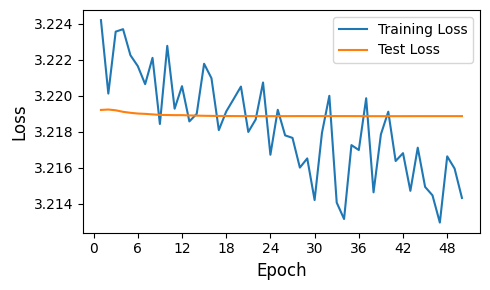

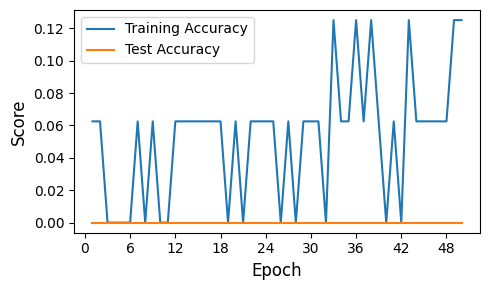

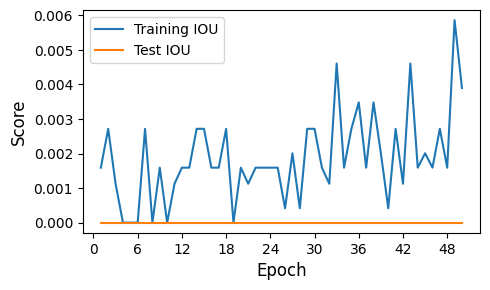

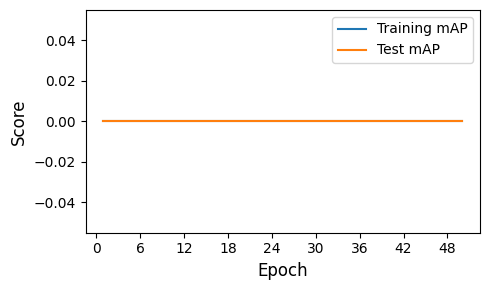

In [144]:
epochs = list(range(1, num_epochs + 1))

# Plot losses
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, test_losses, label='Test Loss')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_3/loss.svg')

# Plot accuracy
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_acc, label='Training Accuracy')
ax.plot(epochs, test_acc, label='Test Accuracy')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Score', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_3/accuracy.svg')

# Plot accuracy
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_iou, label='Training IOU')
ax.plot(epochs, test_iou, label='Test IOU')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Score', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_3/iou.svg')

# Plot accuracy
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_map, label='Training mAP')
ax.plot(epochs, test_map, label='Test mAP')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Score', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_3/map.svg')


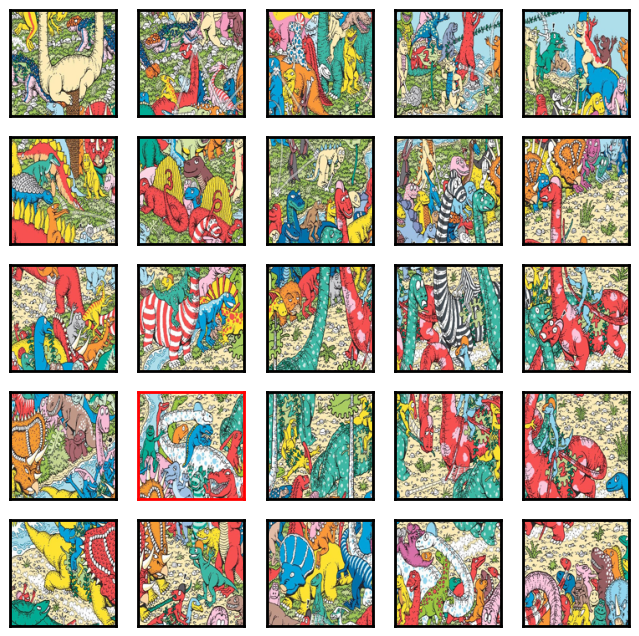

In [150]:
def show_random_prd_image_patch(model, dataset, patches_div, device):
    # Choose a random index for image
    random_idx = random.randint(0, len(dataset) - 1)
    # Get the image and label
    img, lbl = dataset[random_idx]
    
    # Make prediction
    with torch.no_grad():
        img = img.to(device)
        box_prd = model(img)
        box_prd = box_prd.reshape(patches_div * patches_div)
        prd_idx = box_prd.argmax()

    # Calulate patch
    prd_h = prd_idx // patches_div
    prd_w = prd_idx % patches_div
    patch = prd_h, prd_w

    depth, height, width = img.shape
    waldo_mid = (lbl[:2] + lbl[2:]) / 2
    waldo_patch_h = int(waldo_mid[1] / (height / patches_div))
    waldo_patch_w = int(waldo_mid[0] / (width / patches_div))

    show_image_patches(img.detach().cpu(), patch, patches_div)


show_random_prd_image_patch(patch_model, patch_dataset, 5, device)

In [151]:
# Save the model state
torch.save(patch_model.state_dict(), './checkpoints/patch_model_state_dict.pth')

In [152]:
patch_model = PatchBasedClassification(binary_model, patches_div).to(device)
patch_model.load_state_dict(torch.load('./checkpoints/patch_model_state_dict.pth'))

<All keys matched successfully>